# Project 1: Lane detection

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Global variables

In [2]:
DEBUG = True # on debug mode output will be more verbose
video_repo = 'test_videos'
image_repo = 'test_images'

## Helper function for image mask (region of interest, yellow and white color mask)

In [3]:
def region_of_interest(img, vertices=None):
    """
    return interest zone mask
    """
    # if vertices are not provided generate simple polugon of interest zone
    if not vertices:
        ysize = img.shape[0]
        xsize = img.shape[1]
        
        x_offset = xsize // 20
        vertices = np.array([[(x_offset*2, ysize), 
                              (xsize//2-100, ysize//1.6), 
                              (xsize//2+140, ysize//1.6),
                              (xsize-x_offset, ysize) 
                             ]], dtype=np.int32)
    
    # defining a blank mask to start with
    mask = np.zeros_like(img)  
    
    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    return mask
    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def color_mask(hsv_image, lower_bound, upper_bound):
    """ return mask for color """
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
    return mask


## Helper Functions for image preprocessing

In [4]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def gaussian_blur(img):
    # bigger size, more blur
    kernel_size = 7 # can be 5, 7, 11 
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def cannyfy(img):
    strength = 70
    low_threshold = 1 * strength
    high_threshold = 3 * strength
    return cv2.Canny(img, low_threshold, high_threshold)


def hough_lines(img):
    """
        apply probabilistic hough lines algo 
        on image(canny algo output) and 
        return list of lines [(x1, y1, x2, y2), ...]
    """
    # define params for Hough algo
    rho = 1.0
    theta = np.pi / 180
    threshold = 20
    min_line_length = 10
    max_gap_length = 20
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                          min_line_length, max_gap_length)
    
    return lines


def draw_line_on_image(img, x1, y1, x2, y2, line_color, line_thickness):
    """ draw line on image (inplace)"""
    cv2.line(img, (x1, y1), (x2, y2), line_color, line_thickness)

    
def get_slope(x1, y1, x2, y2):
    slope, y_inter = np.polyfit((x1, x2), (y1, y2), 1)
    return slope


# TO DO: extrapolate [DONE]
def extrapolate_line(x1, y1, x2, y2, y_top, y_bot):
    """
        extrapolate line towards top and botom using y = mx + b formula
        return extrapolated line in array
        array with int type becaues float coordx cant be drawn
    """
    m, b = np.polyfit([x1, x2], [y1, y2], 1)
    y2 = y_top
    x2 = (y2-b) / m
    y1 = y_bot
    x1 = (y1-b) / m
    return np.array([x1, y1, x2, y2], dtype=np.int32)


# TO DO: avarage lines [DONE]
def avarage_line(lines):
    """
        lines parameter is list of lines of (left or right side)
        return one line avarage of given lines
    """
    avarage = np.mean(np.array([lines]), axis=1)
    # np.mean may return floats so before return convert to int
    return np.array(avarage, dtype=np.int)
    
    
# TO DO: save last N lines and use them for line stabilization
def draw_lines(img, lines):
    """
        return image with extrapolated lines drawn on it
    """
    # TO DO: separate lines to left and right
    left_lines = []
    right_lines = []
    red = [255, 0, 0] # red color for rgb image
    green = [0, 255, 0] # green color for rgb image
    blue = [0, 0, 255] # blue color for rgb image
    ysize = img.shape[0]
    xsize = img.shape[1]
    y_top = ysize / 1.6
    y_bot = ysize - 20
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = get_slope(x1, y1, x2, y2)
            # TO DO: better slope filter
            if -0.9 < slope < -0.5:
                left_lines.append(line)
            elif 0.5 < slope < 0.9:
                right_lines.append(line)
    
    if left_lines:
        avarage_left = avarage_line(left_lines)
        # unpack variables
        left_avg_x1, left_avg_y1, left_avg_x2, left_avg_y2 = avarage_left[0][0]
        # extrapolate left line using slope formula y = mx + b
        left_line = extrapolate_line(left_avg_x1, left_avg_y1, 
                                     left_avg_x2, left_avg_y2,
                                     y_top, y_bot)
        draw_line_on_image(img, *left_line, red, 10)
        
    
    if right_lines:
        avarage_right = avarage_line(right_lines)
        # unpack variables
        right_avg_x1, right_avg_y1, right_avg_x2, right_avg_y2 = avarage_right[0][0]
        # extrapolate right line using slope formula y = mx + b
        right_line = extrapolate_line(right_avg_x1, right_avg_y1, 
                                      right_avg_x2, right_avg_y2,
                                      y_top, y_bot)
        draw_line_on_image(img, *right_line, green, 10)
    
    return img

# Image processing Pipline

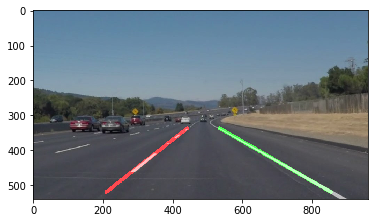

In [10]:
# TO DO: improve pipline for challenge video
# TO DO: store globally last lines  (use if lines not detected)
def image_processing(image):
    blur_image = gaussian_blur(image)
    gray_image = grayscale(blur_image)
    
    # convert from rgb color space to hsv color space
    hsv_img = cv2.cvtColor(blur_image, cv2.COLOR_RGB2HSV)
    
    # TO DO: make white color mask [DONE]
    white_mask = color_mask(hsv_img, 
                            np.array([0, 0, 173]), 
                            np.array([124, 34, 255]))
    
    # TO DO: make yellow color mask [DONE]
    yellow_mask = color_mask(hsv_img, 
                             np.array([10, 0, 186]), 
                             np.array([42, 255, 255]))
    
    # TO DO: make mask for region of interest [DONE]
    region_mask = region_of_interest(image)
    
    # TODO combine all mask and apply on image [DONE]
    masked_by_region = cv2.bitwise_and(image, region_mask)
    masked_by_color = cv2.bitwise_and(image, image, 
                                      mask=yellow_mask + white_mask)
    combo = np.bitwise_and(masked_by_color, masked_by_region)
    
    # TO DO: detect line [DONE]
    edges = cannyfy(combo)
    lines = hough_lines(edges)
    
    # TO DO: draw detected lines on blank image [DONE]
    line_image = draw_lines(np.zeros_like(image), lines)
    
    # TO DO: overlay image with lines on initial image [DONE]
    result = cv2.addWeighted(image, 0.8, line_image, 1.0, 0.0)
    
    return result

image = mpimg.imread('test.jpg')
result = image_processing(image)
plt.imshow(result, cmap='gray')
plt.savefig('result_test.jpg')

## Test on images

In [ ]:
# plt.imshow(image_processing(image), cmap='gray')
import os
f, axs = plt.subplots(2, 3, figsize=(24, 9))
for i, image_file in enumerate(os.listdir('test_images/')):
    if image_file.startswith('result_'):
        continue
    path = os.path.join('test_images', image_file)
    # process image
    image = mpimg.imread(path)
    result = image_processing(image)
    # display result images
    axs[i//3][i%3].imshow(result, cmap='gray') 
    axs[i//3][i%3].set_title(image_file, fontsize=20)

f.tight_layout()

## Test on video

In [ ]:
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def video_processing(path):
    """
        video for testing suppose to be at ./test_videos/challenge.mp4
        result video suppose to be at ./test_videos/result_challenge.mp4
        
        return path for result video
    """
    # parsing path and filename
    video_file = os.path.basename(path)
    video_dir = os.path.dirname(path)
    video_output = os.path.join(video_dir, 'result_' + video_file)
    print(video_file, video_dir, video_output)
    
    # processing video
    video_clip = VideoFileClip(path)
    output_clip = video_clip.fl_image(image_processing)
    %time output_clip.write_videofile(video_output, audio=False)
    
    return video_output


videos = [
    'solidWhiteRight.mp4',
    'solidYellowLeft.mp4',
    'challenge.mp4',
]

videos_result = []
for video in videos:
    path_to_video = os.path.join('test_videos', video)
    result_video = video_processing(path_to_video)
    videos_result.append(result_video)
    
# video_file_name = 'challenge.mp4'
# path_to_video = os.path.join('test_videos', v2)
# print(path_to_video)
# result_video = video_processing(path_to_video)

# video_file_name = 'challenge.mp4'
# path_to_video = os.path.join('test_videos', video_file_name)
# print(path_to_video)
# result_video1 = video_processing(path_to_video)

## Display videos result

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(videos_result[0]))

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(videos_result[1]))

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(videos_result[2]))

## helper function to get hsv values

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import numpy as np
import os

        
def get_video_frames(filename):
    """
        split videos into frames and save that frames in folder
    """
    path = os.path.join('test_videos', filename)
    video_file = os.path.basename(path)
    video_dir = os.path.dirname(path)
    # processing video
    video_clip = VideoFileClip(path)
    # create folder for video frames
    frame_folder = filename.replace('.mp4', '')
    frame_folder_path = os.path.join('video_frames', frame_folder)
    try:
        os.mkdir(frame_folder_path)
    except:
        pass
    # save frames 
    video_clip.write_images_sequence(
        os.path.join(frame_folder_path, 'frame%04d.jpg')
    )

    
# use this function as param for cv2.createTrackBar
def callback(x):
    pass
        

# easy assigments for trackbar names
hh='Hue High'
hl='Hue Low'
sh='Saturation High'
sl='Saturation Low'
vh='Value High'
vl='Value Low'

trackbar_window_name = 'Trackbar tool'
trackbars = [
        (hl, trackbar_window_name, 0, 179, callback),
        (hh, trackbar_window_name, 0, 179, callback),
        (sl, trackbar_window_name, 0, 255, callback),
        (sh, trackbar_window_name, 0, 255, callback),
        (vl, trackbar_window_name, 0, 255, callback),
        (vh, trackbar_window_name, 0, 255, callback),
    ]


# TO DO: get all videos from repo 
def get_hsv_values():
    """
        creates trackbar window and
        creates 2 windows with hsv threshold mask
        move around to play and find color of interes
    """
    cv2.namedWindow(trackbar_window_name, cv2.WINDOW_NORMAL)
    cv2.namedWindow('solidYellowLeft', cv2.WINDOW_NORMAL)
    cv2.namedWindow('challenge', cv2.WINDOW_NORMAL)
    
    for t in trackbars:
        cv2.createTrackbar(*t)
    
    # set default values for upper bounderies
    cv2.setTrackbarPos(hh, trackbar_window_name, 179)
    cv2.setTrackbarPos(sh, trackbar_window_name, 255)
    cv2.setTrackbarPos(vh, trackbar_window_name, 255)
    
    repo = 'video_frames/'
    s_path = os.path.join(repo,'solidYellowLeft')
    solidYellowLeft = os.listdir(s_path)
    solidYellowLeft.sort()
    c_path = os.path.join(repo,'challenge')
    challenge = os.listdir(c_path)
    challenge.sort()
    images = os.listdir(repo)
    images.sort()
    
    while(1):
        for s, c in zip(solidYellowLeft, challenge):
            # frame = cv2.imread(path, 1)
            s_frame = cv2.imread(os.path.join(s_path, s), 1)
            c_frame = cv2.imread(os.path.join(c_path, c), 1)
            #blur = cv2.GaussianBlur(frame,(5,5),0)
            s_blur = cv2.GaussianBlur(s_frame,(5,5),0)
            c_blur = cv2.GaussianBlur(c_frame,(5,5),0)
            #convert to HSV from BGR
            #hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
            s_hsv = cv2.cvtColor(s_blur, cv2.COLOR_BGR2HSV)
            c_hsv = cv2.cvtColor(c_blur, cv2.COLOR_BGR2HSV)

            # get trackbar positions for all
            hul=cv2.getTrackbarPos(hl, trackbar_window_name)
            huh=cv2.getTrackbarPos(hh, trackbar_window_name)
            sal=cv2.getTrackbarPos(sl, trackbar_window_name)
            sah=cv2.getTrackbarPos(sh, trackbar_window_name)
            val=cv2.getTrackbarPos(vl, trackbar_window_name)
            vah=cv2.getTrackbarPos(vh, trackbar_window_name)
            # make array for final values
            HSVLOW=np.array([hul,sal,val])
            HSVHIGH=np.array([huh,sah,vah])

            # apply hsv ranges on a mask
            # mask = cv2.inRange(hsv,HSVLOW, HSVHIGH)
            s_mask = cv2.inRange(s_hsv,HSVLOW, HSVHIGH)
            c_mask = cv2.inRange(c_hsv,HSVLOW, HSVHIGH)
            # res = cv2.bitwise_and(frame,frame, mask =mask)
            s_res = cv2.bitwise_and(s_frame, s_frame, mask=s_mask)
            c_res = cv2.bitwise_and(c_frame, c_frame, mask=c_mask)
            
            # cv2.imshow('input', frame)
            cv2.imshow('solidYellowLeft', s_res)
            cv2.imshow('challenge', c_res)
            # cv2.imshow('output', res)
            k = cv2.waitKey(5) & 0xFF
            if k == 27:
                print (HSVLOW, HSVHIGH)
                break   

# get_video_frames('solidYellowLeft.mp4')
# get_video_frames('challenge.mp4')
# get_hsv_values()


hsv_for_images = False
if hsv_for_images:
    """
        creates trackbar window and
        creates windows for images from directory test_images/ 
        move around trackbar to play and find color of interes
    """
    cv2.namedWindow(trackbar_window_name)

    # create trackbars on Trackbar window
    for t in trackbars:
        cv2.createTrackbar(*t)
    # set default values for upper bounderies
    cv2.setTrackbarPos(hh, trackbar_window_name, 179)
    cv2.setTrackbarPos(sh, trackbar_window_name, 255)
    cv2.setTrackbarPos(vh, trackbar_window_name, 255)
    
    while(1):
        images = []
        # read image and create window for it
        for i, image_file in enumerate(os.listdir('test_images/')):
            if image_file.startswith('result_'):
                continue
            path = os.path.join('test_images', image_file)
            # process image
            image = mpimg.imread(path)
            images.append(cv2.imread(path, 1))
            cv2.namedWindow('image ' + str(i), cv2.WINDOW_NORMAL)
        
        # process images
        for i, image in enumerate(images):

            blur = cv2.GaussianBlur(image,(5,5),0)
            hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)

            #read trackbar positions for upper and lower hsv values
            lowers = (
                cv2.getTrackbarPos(hl, trackbar_window_name),
                cv2.getTrackbarPos(sl, trackbar_window_name),
                cv2.getTrackbarPos(vl, trackbar_window_name),
            )
            uppers = (
                cv2.getTrackbarPos(hh, trackbar_window_name),
                cv2.getTrackbarPos(sh, trackbar_window_name),
                cv2.getTrackbarPos(vh, trackbar_window_name),
            )

            # define low and up bounderies
            HSVLOW=np.array([*lowers])
            HSVHIGH=np.array([*uppers])

            #apply the range on a mask
            mask = cv2.inRange(hsv,HSVLOW, HSVHIGH)
            res = cv2.bitwise_and(image, image, mask=mask)

            # cv2.imshow('input', frame)
            cv2.imshow('image ' + str(i), res)
            # cv2.imshow('output', res)
            k = cv2.waitKey(5) & 0xFF
            if k == 27:
                print(HSVLOW, HSVHIGH)
                break  